In [439]:
#!pip install leidenalg
#!pip install --user scikit-misc
import leidenalg
import scanpy as sc
import pandas as pd

In [441]:
# Reading the file and creating an adata object
file = 'neu_count_matrix.csv'
adata = sc.read_text(file, delimiter=',').T 
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

normalizing counts per cell
    finished (0:00:00)


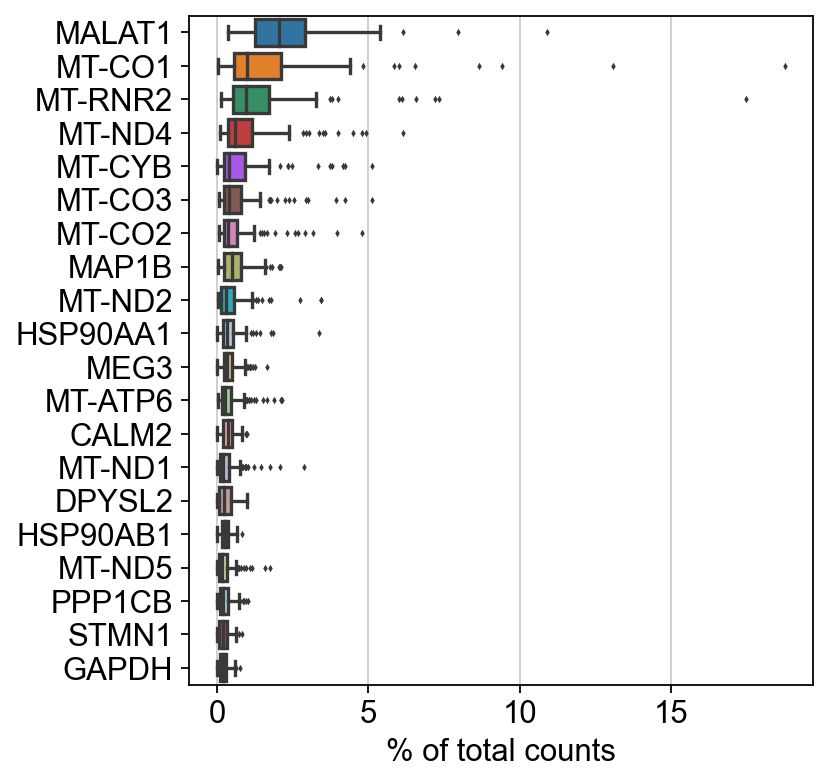

In [442]:
# Visualisation of the top 20 highest expresses genes for all neurons
sc.pl.highest_expr_genes(adata, n_top=20, )

In [443]:
# Adds a column with a boolean whether a mitochrondrial gene is present
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Selecting cells that have a % mitochondrial count of less than 10%
adata = adata[adata.obs.pct_counts_mt < 10, :]

# Remove mitochondrial genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes_list]

In [444]:
# Logarithmize the data matrix.
sc.pp.log1p(adata)

# Filter out low detection genes
sc.pp.filter_genes(adata, min_cells=3)

filtered out 20249 genes that are detected in less than 3 cells


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


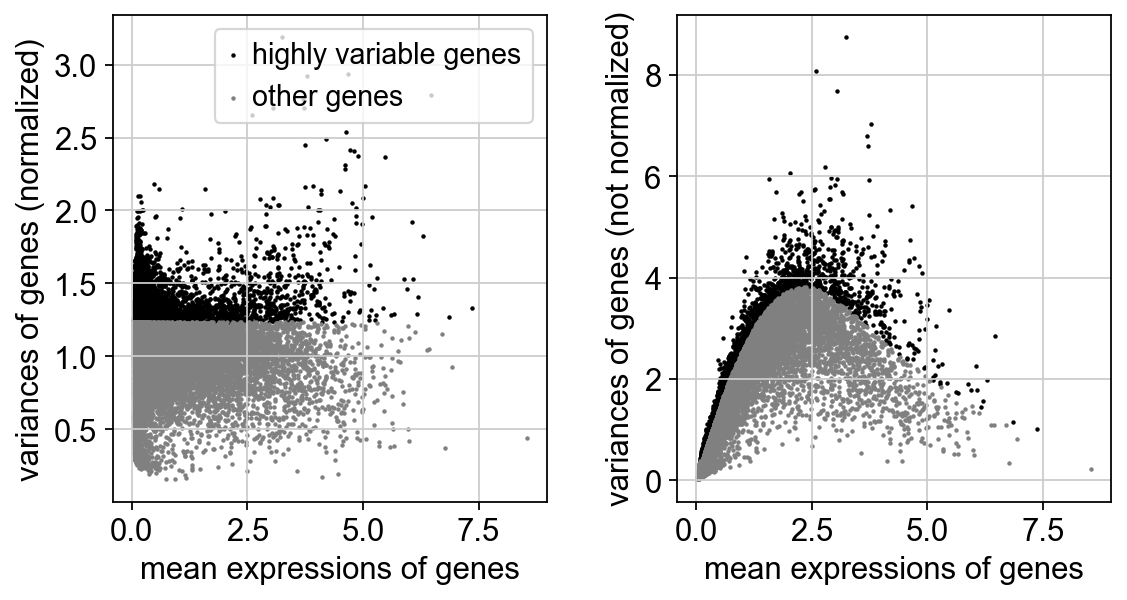

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
A2M,False,28,6.435114,78.625954,843.0,21,True,3190.0,0.560017,1.603436,1.270370
A2MP1,False,14,2.267176,89.312977,297.0,12,True,2725.0,0.328068,0.961829,1.294876
AAAS,False,29,10.122137,77.862595,1326.0,21,True,2613.0,0.583259,1.706816,1.300902
AASS,False,29,14.152672,77.862595,1854.0,23,True,806.0,0.589657,1.977024,1.491210
ABCA1,False,74,54.122139,43.511450,7090.0,60,True,368.0,2.198557,4.954676,1.606818
...,...,...,...,...,...,...,...,...,...,...,...
ZWINT,False,4,0.725191,96.946565,95.0,3,True,251.0,0.082914,0.290476,1.659630
ZXDA,False,13,2.328244,90.076336,305.0,11,True,2132.0,0.258597,0.785081,1.333559
ZXDB,False,14,3.374046,89.312977,442.0,14,True,1885.0,0.371272,1.133858,1.353067
ZXDC,False,19,3.748092,85.496183,491.0,14,True,3947.0,0.341795,0.957057,1.238370


In [445]:
# Highly variable genes using default calues
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata)
adata.var[adata.var.highly_variable]

In [446]:
# Filtering out the genes that aren't highly variable
adata = adata[:, adata.var.highly_variable]

# Regress out (mostly) unwanted sources of variation.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scale data to unit variance and zero mean.
sc.pp.scale(adata, max_value=10)

# Selecting cells that have a % mitochondrial count of less than 10%
adata = adata[adata.obs.pct_counts_mt < 10, :]

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:04)


## Clustering

In [447]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=15)
sc.tl.tsne(adata)
sc.tl.leiden(adata, resolution=1.2)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 15
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


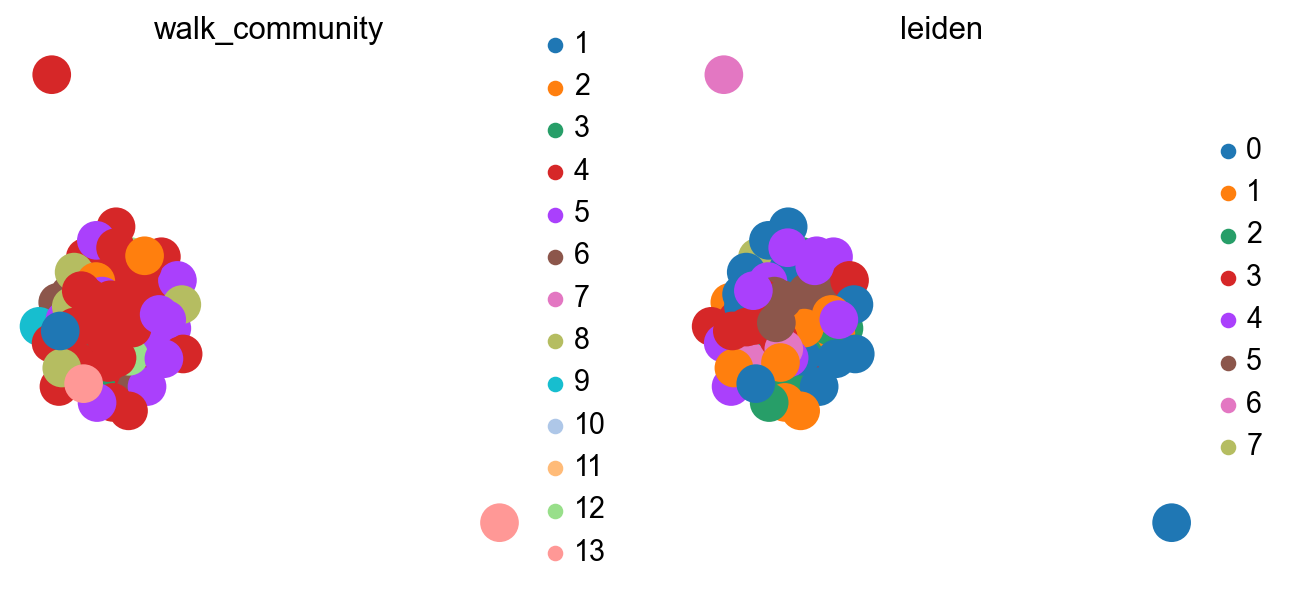

In [448]:
# Read the lists generated from R and set index row name
walk_communities = pd.read_csv("neu_identity.csv", delimiter=",")
#walk_communities.head(5)

# Creating a dictionary 
community_dict = walk_communities.set_index("names")["community"].to_dict()

adata.obs["walk_community"] = adata.obs.index.map(community_dict)
adata.obs['walk_community']=adata.obs['walk_community'].astype(str)

sc.pl.tsne(adata, color = ['walk_community', 'leiden'], frameon = False,)

In [449]:
# Checking the number of members within each community
category_records = adata.obs["walk_community"].value_counts()
category_records

walk_community
4     50
5     16
6      8
8      6
11     5
7      3
13     3
2      2
12     2
1      1
3      1
9      1
10     1
Name: count, dtype: int64

In [450]:
# Removing cells belonging to community comprised of less than one member
for category in category_records.index:
    if category_records[category] < 2:
        adata = adata[adata.obs["walk_community"] != category, :]

walk_community
4     50
5     16
6      8
8      6
11     5
7      3
13     3
2      2
12     2
Name: count, dtype: int64

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/li

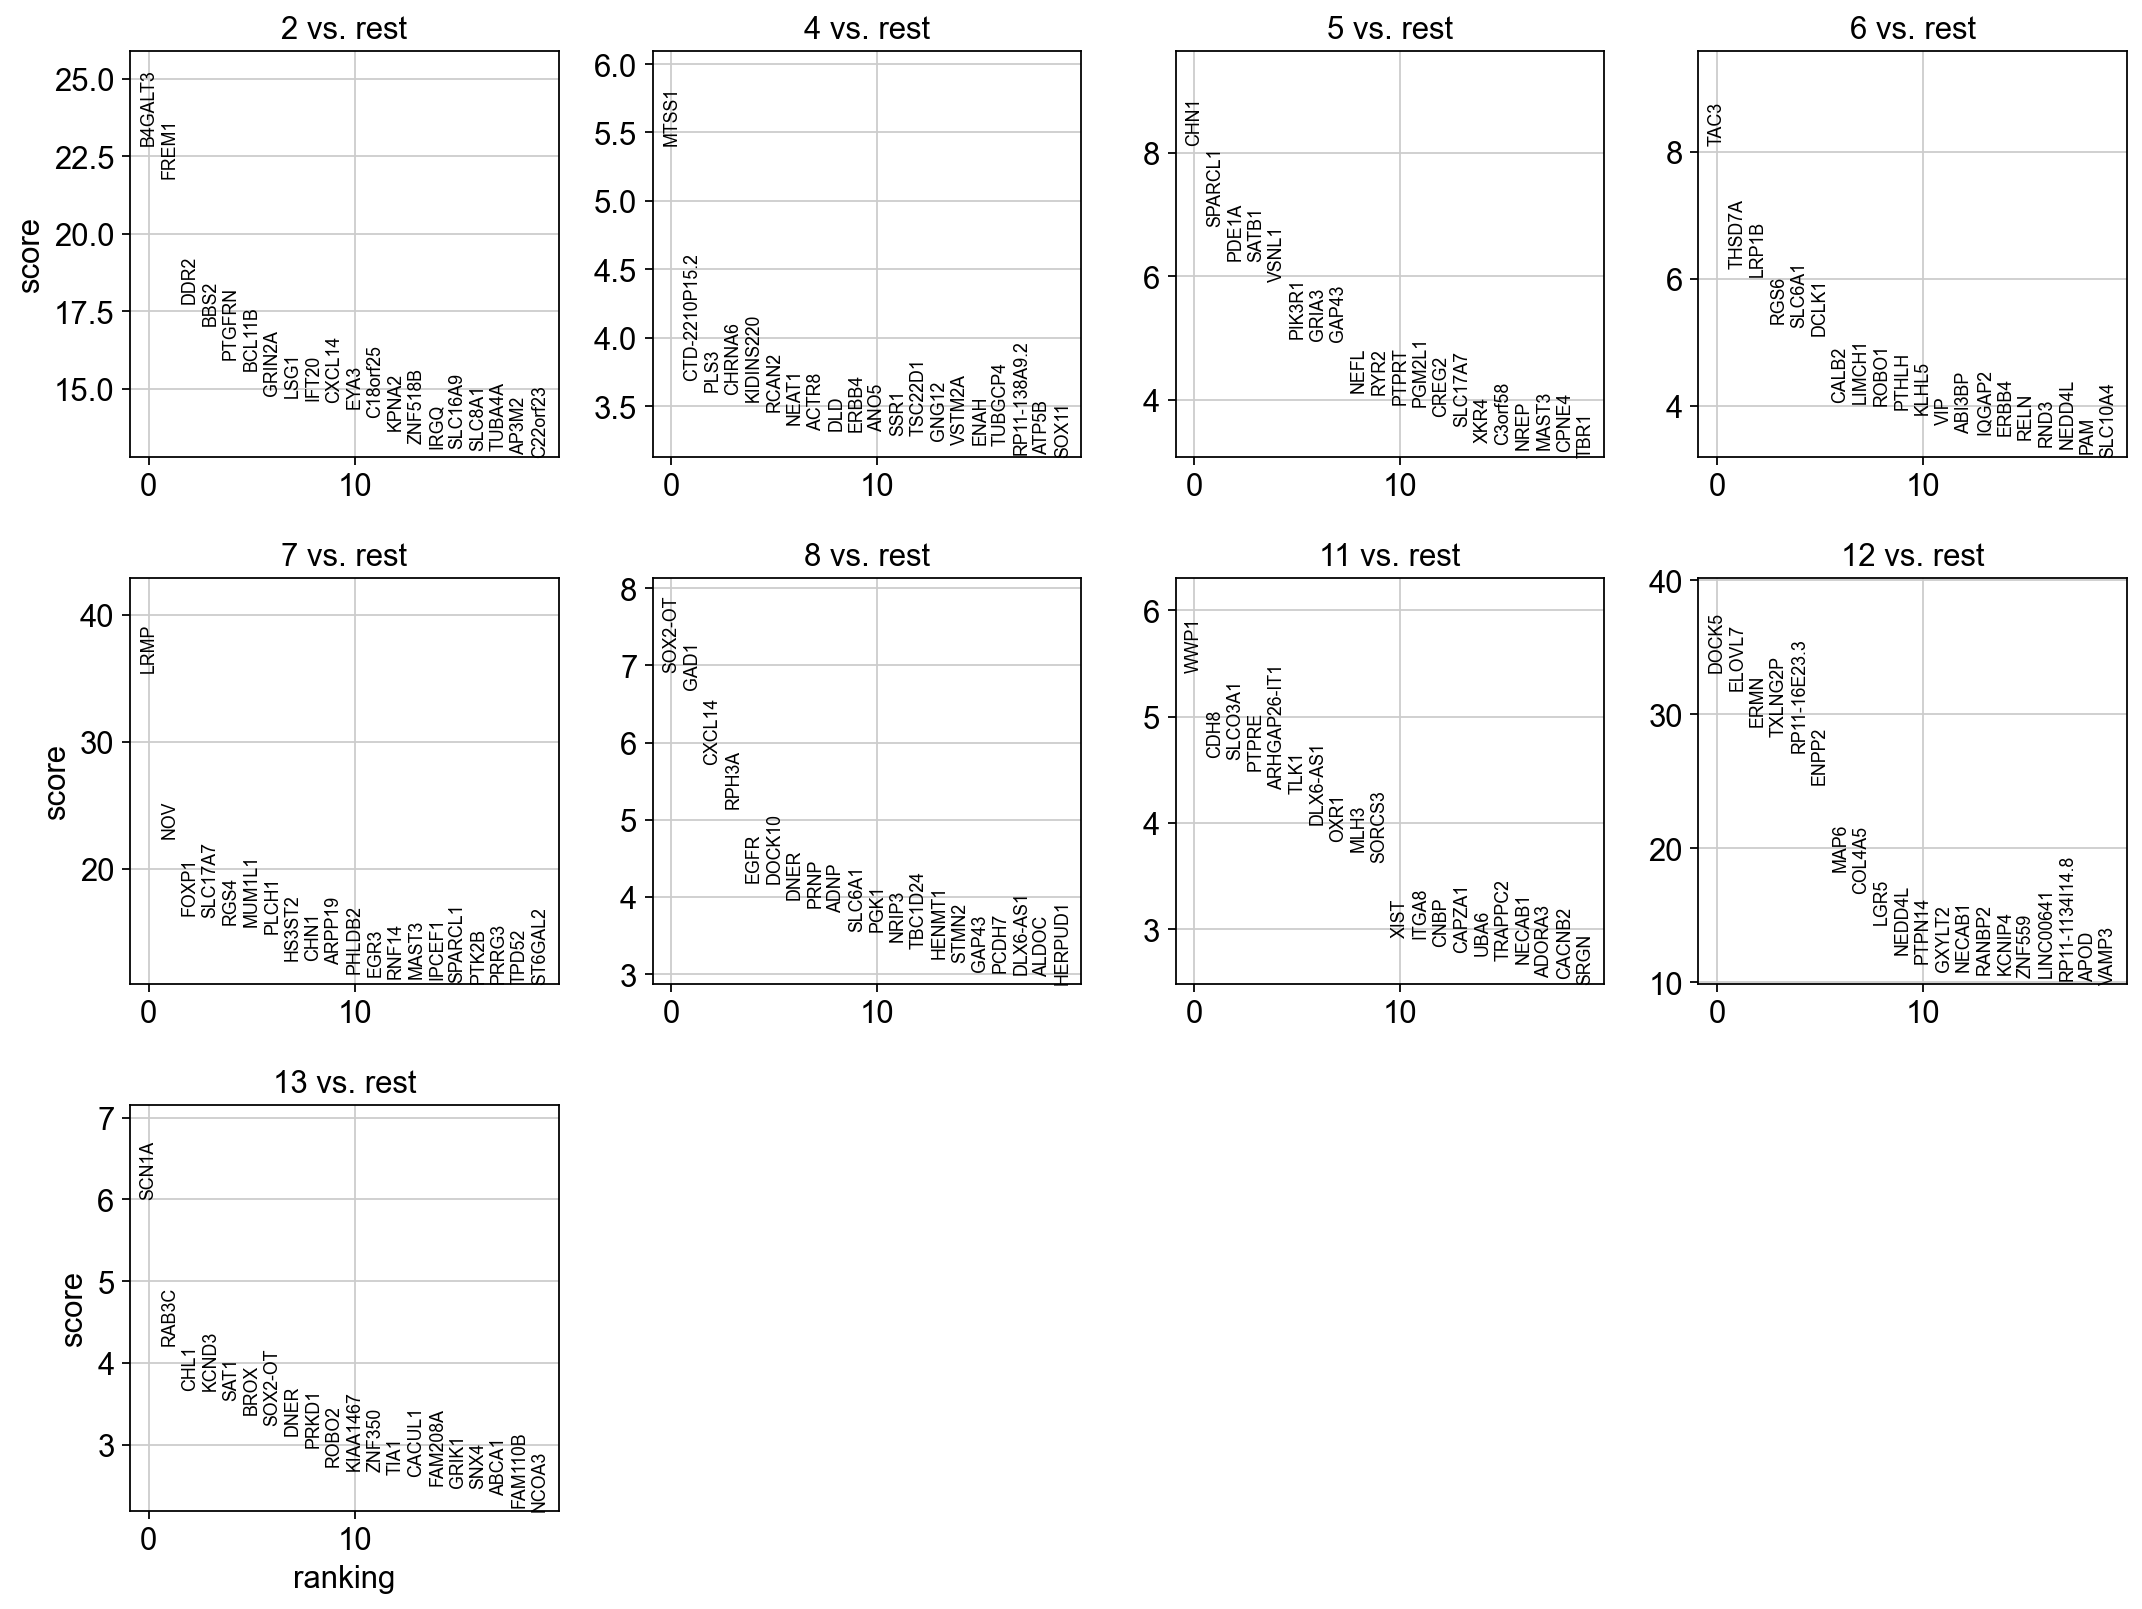

walk_community
4     50
5     16
6      8
8      6
11     5
7      3
13     3
2      2
12     2
Name: count, dtype: int64

In [466]:
# Find the marker gene of each remaining random walk community
sc.tl.rank_genes_groups(adata, groupby='walk_community', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

adata.obs["walk_community"].value_counts()

In [495]:
# Identify highly correlated and significantly overexpressed unique gene expression signature that would have suggested its role in the network niche
markers = sc.get.rank_genes_groups_df(adata, None)
markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]

,group,names,scores,logfoldchanges,pvals,pvals_adj
58,2,ZNF385D,7.485006,6.708599,1.230589e-04,2.130891e-03
66,2,POMGNT2,7.000259,8.188662,5.360698e-06,1.607931e-04
71,2,SOX4,6.768931,6.976176,1.904457e-09,1.620814e-07
78,2,SLC10A4,6.610746,6.985295,2.096800e-06,6.989333e-05
89,2,TMEM33,6.208384,6.626701,1.487275e-08,9.187877e-07
...,...,...,...,...,...,...
35952,13,SLC9A6,-7.125464,6.321296,4.240344e-07,2.449193e-05
35981,13,ARHGAP26-IT1,-8.993368,6.563534,1.645474e-10,2.632759e-08
35982,13,NEFL,-9.063420,7.896276,4.177047e-12,9.828346e-10
35983,13,CDH9,-9.092849,5.702063,1.777081e-14,7.108323e-12


In [497]:
# Genes for community 4,5,6
# markers[markers.group.isin([4,5,6])]

,group,names,scores,logfoldchanges,pvals,pvals_adj


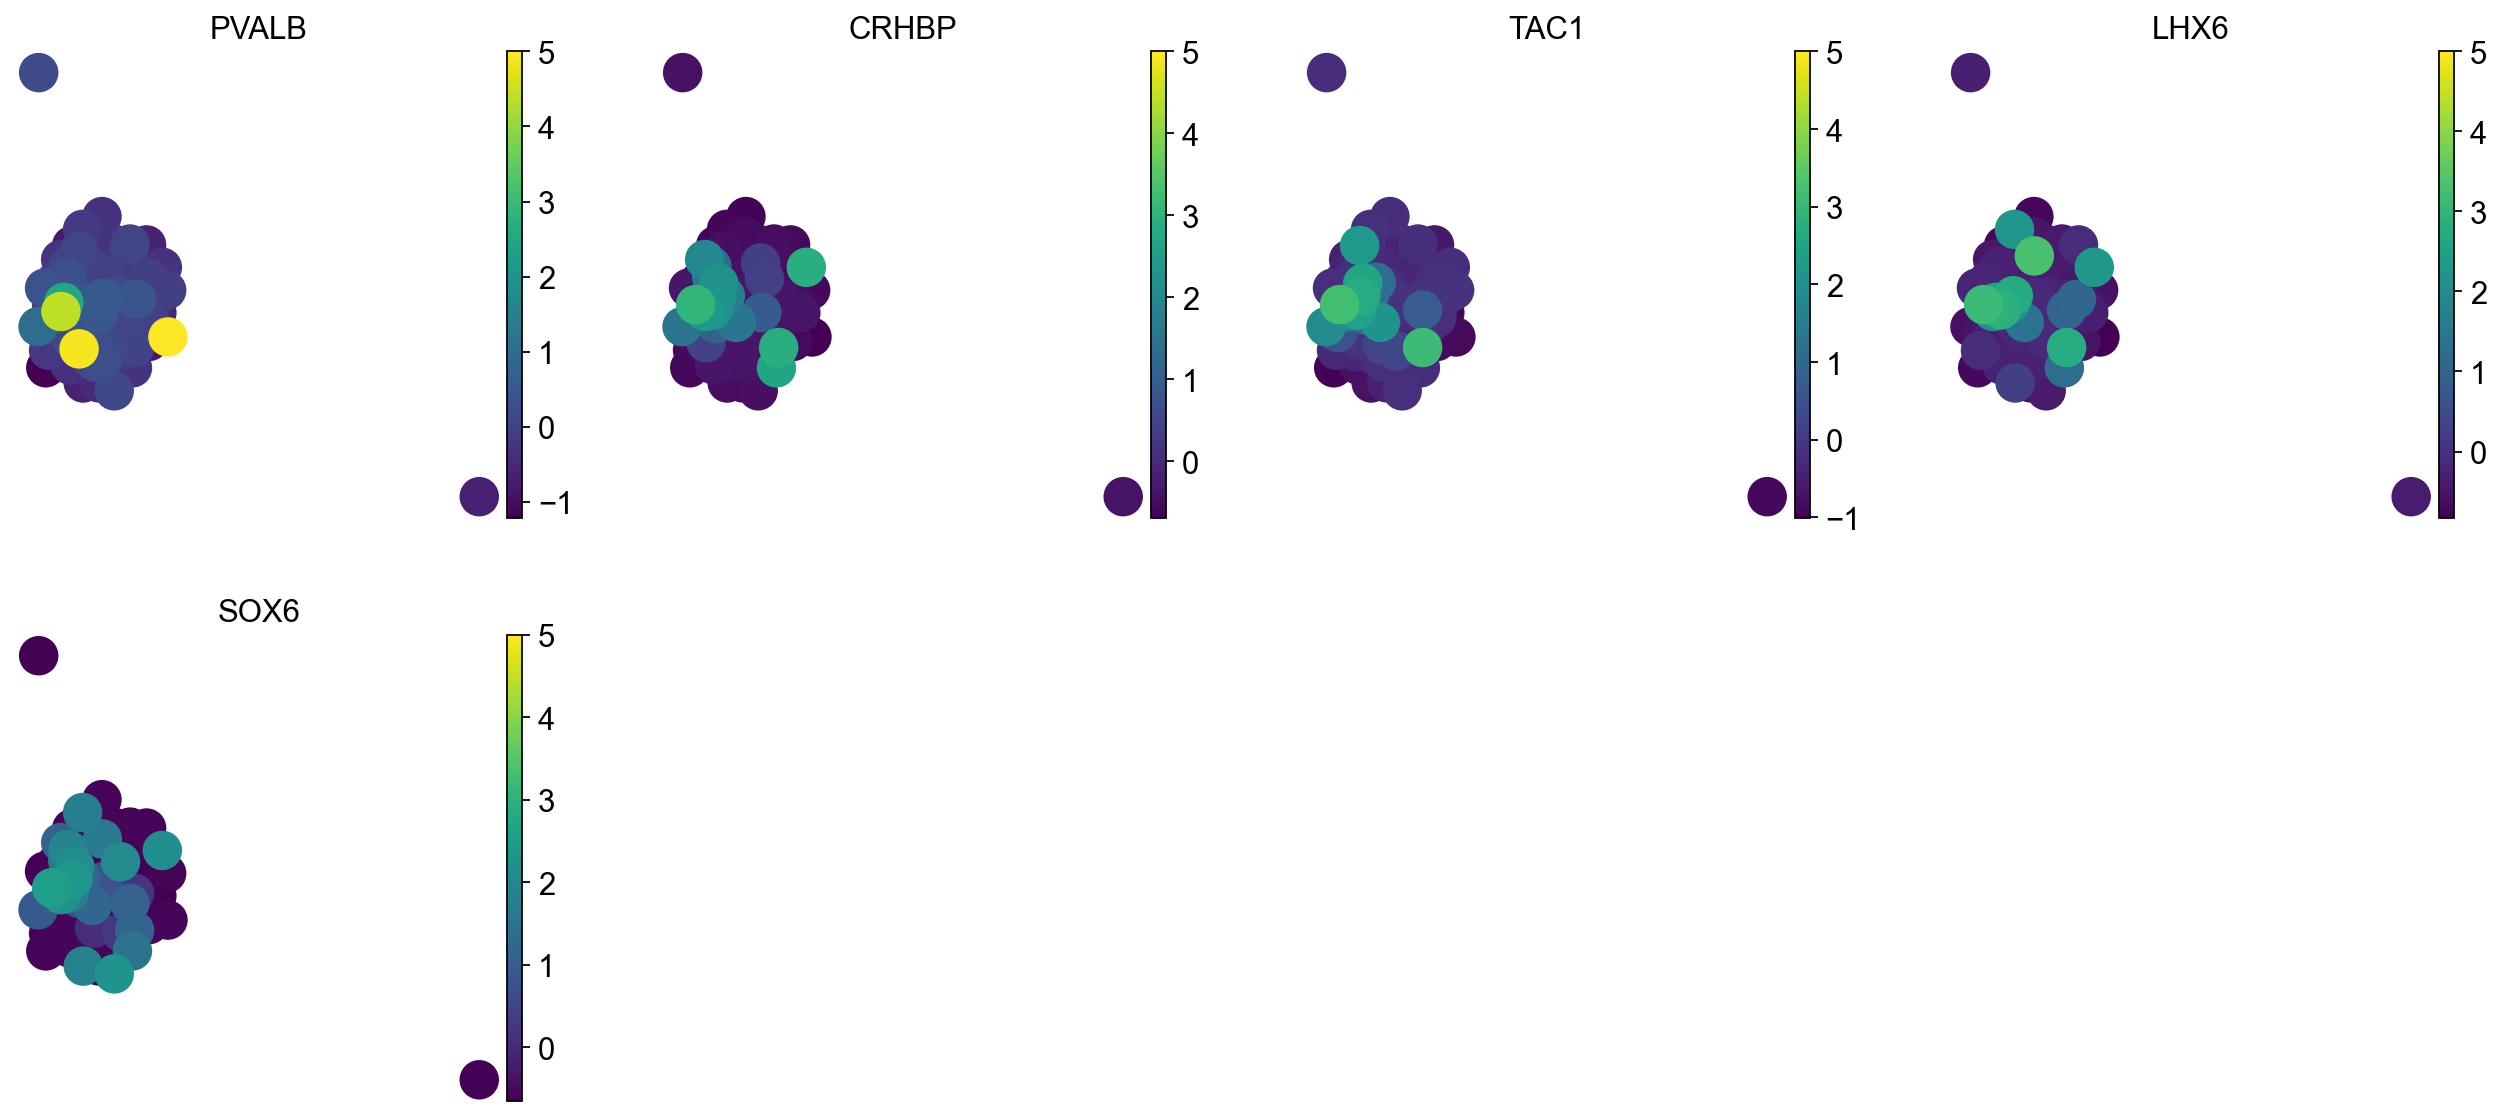

In [455]:
# GABAergic neurons
sc.pl.tsne(adata, color = ["PVALB", "CRHBP", "TAC1", "LHX6", "SOX6"], frameon = False, vmax = 5)

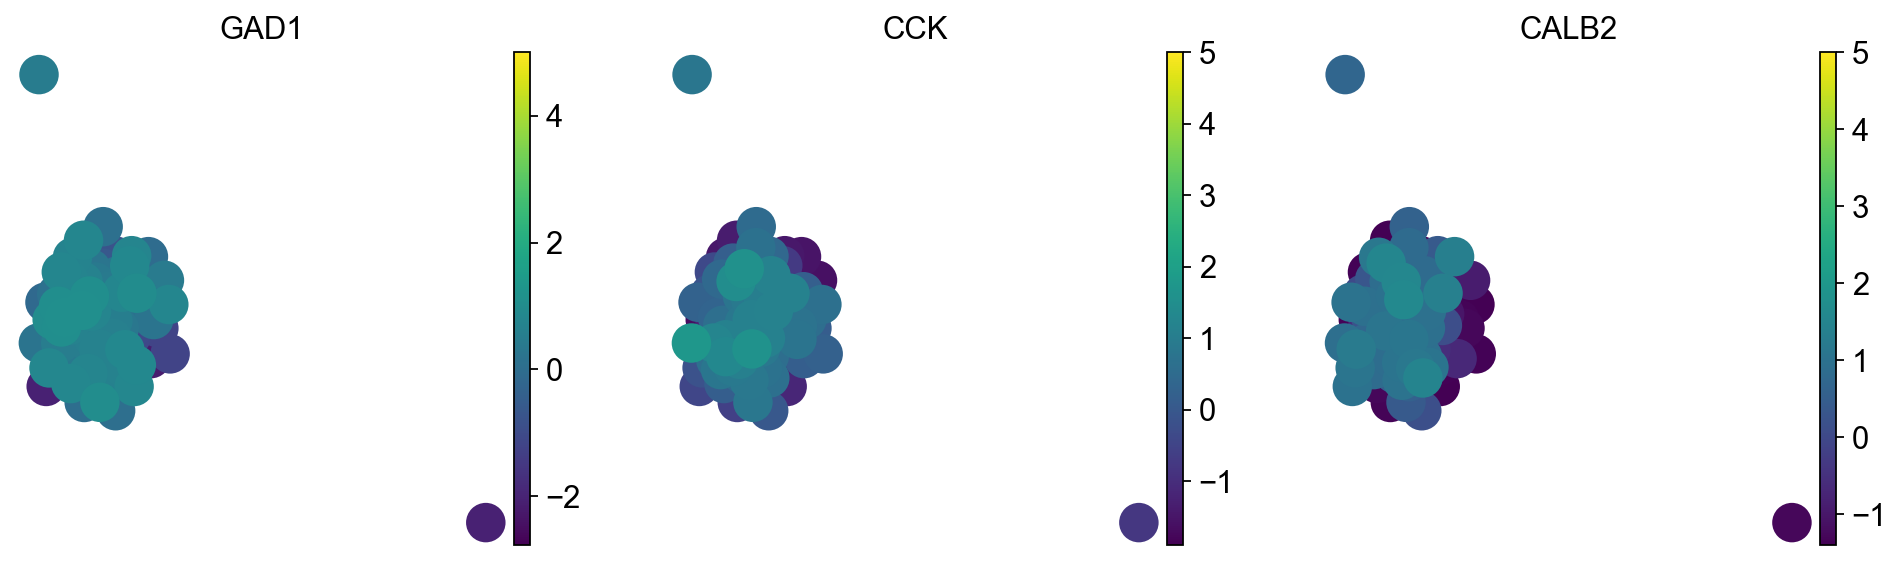

In [457]:
# Inhibitory/Interneurons
sc.pl.tsne(adata, color = ["GAD1", "CCK", "CALB2"], frameon = False, vmax = 5)

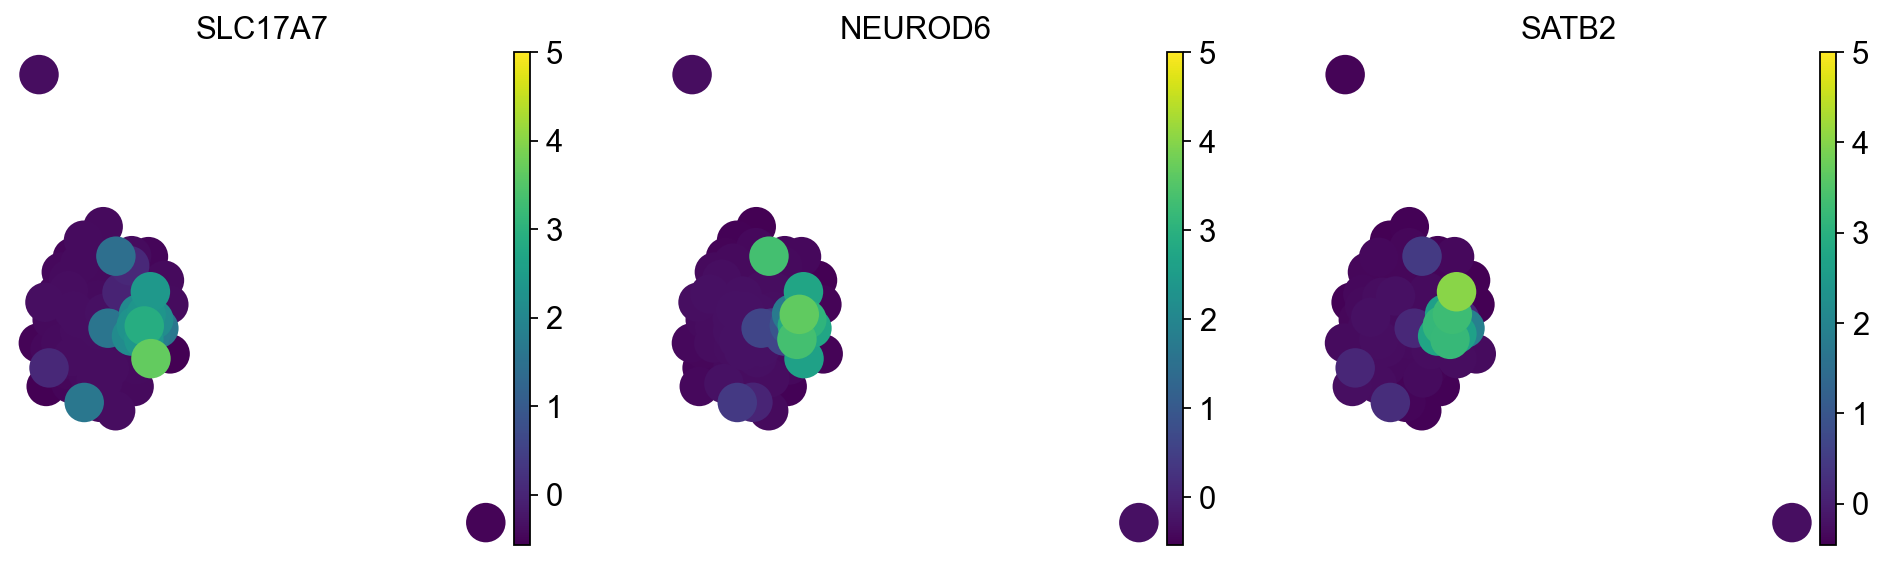

In [456]:
# Excitatory communities
sc.pl.tsne(adata, color = ["SLC17A7","NEUROD6","SATB2"], frameon = False, vmax = 5)